## Setup code
First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.


In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Nerf_Colab"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['__pycache__', 'load_LINEMOD.py', 'load_deepvoxels.py', 'logs', 'run_nerf_helpers.py', 'Nerf_PyTorch.ipynb', 'load_blender.py', 'run_nerf.py', 'run_nerf.ipynb', 'load_llff.py', 'Nerf_PyTorch_new.ipynb']


In [ ]:
import sys
# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()
last_edit_time = time.ctime(os.path.getmtime(GOOGLE_DRIVE_PATH))
print("NeRF last edited on %s" % last_edit_time)

NeRF last edited on Fri Aug  5 01:08:23 2022


In [ ]:
import math
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

!pip install configargparse
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.4 MB/s 


In [ ]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Good to go!


# Check Colab GPU Type

In [ ]:
!nvidia-smi

Fri Aug  5 01:19:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Load Dataset


In [ ]:
if os.path.isfile("./nerf_example_data.zip"):
    print("data exists!")
else:
    print("Downloading dataset")
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip
    !unzip nerf_example_data.zip -d ./data

data exists!


##Load Parameters

In [ ]:
from run_nerf import load_params

class construct_config:
    dataset_type = "blender"
    basedir = os.path.join(GOOGLE_DRIVE_PATH, "logs")

    if dataset_type == "blender":
        expname = "blender_paper_lego"
        datadir = "./data/nerf_synthetic/lego"

    elif dataset_type == "llff":
        expname = "llff_paper_fern"
        datadir = "./data/nerf_llff_data/fern"

    else:
        print("This script does not support dataset type other than `blender` and `llff`.") 

    no_batching = True

    use_viewdirs = True
    white_bkgd = True
    lrate_decay = 500

    N_samples = 64
    N_importance = 64 # 128
    N_rand = 1024

    precrop_iters = 500
    precrop_frac = 0.5

    half_res = True
    netdepth = 6
    netdepth_fine = 6
    netwidth = 128
    netwidth_fine = 128

    skips = 2

config = construct_config()
args = load_params(config)

## Train the model

In [ ]:
import os, sys
import numpy as np
import imageio
import json
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

from run_nerf_helpers import *
from run_nerf import *

from load_llff import load_llff_data
from load_deepvoxels import load_dv_data
from load_blender import load_blender_data
from load_LINEMOD import load_LINEMOD_data

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

train(args)

Loaded blender (138, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] ./data/nerf_synthetic/lego
Found ckpts ['drive/My Drive/Nerf_Colab/logs/blender_paper_lego/010000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/020000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/030000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/040000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/050000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/060000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/070000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/080000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/090000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/100000.tar']
Reloading from drive/My Drive/Nerf_Colab/logs/blender_paper_lego/100000.tar
Not ndc!
Begin
TRAIN views are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 4

  0%|          | 0/1 [00:00<?, ?it/s]

Saved checkpoints at drive/My Drive/Nerf_Colab/logs/blender_paper_lego/100000.tar



  0%|          | 0/40 [00:00<?, ?it/s]

Generated image 0 using 0.02s



  2%|▎         | 1/40 [00:08<05:15,  8.09s/it]

torch.Size([400, 400, 3]) torch.Size([400, 400])
Generated image 1 using 8.09s



  5%|▌         | 2/40 [00:16<05:13,  8.24s/it]

Generated image 2 using 8.35s



  8%|▊         | 3/40 [00:24<05:09,  8.37s/it]

Generated image 3 using 8.52s



 10%|█         | 4/40 [00:33<05:02,  8.41s/it]

Generated image 4 using 8.46s



 12%|█▎        | 5/40 [00:41<04:52,  8.37s/it]

Generated image 5 using 8.30s



 15%|█▌        | 6/40 [00:49<04:42,  8.30s/it]

Generated image 6 using 8.18s



 18%|█▊        | 7/40 [00:57<04:31,  8.23s/it]

Generated image 7 using 8.09s



 20%|██        | 8/40 [01:06<04:21,  8.17s/it]

Generated image 8 using 8.02s



 22%|██▎       | 9/40 [01:14<04:11,  8.12s/it]

Generated image 9 using 8.02s



 25%|██▌       | 10/40 [01:22<04:03,  8.10s/it]

Generated image 10 using 8.05s



 28%|██▊       | 11/40 [01:30<03:54,  8.10s/it]

Generated image 11 using 8.10s



 30%|███       | 12/40 [01:38<03:47,  8.12s/it]

Generated image 12 using 8.16s



 32%|███▎      | 13/40 [01:46<03:40,  8.15s/it]

Generated image 13 using 8.21s



 35%|███▌      | 14/40 [01:54<03:32,  8.18s/it]

Generated image 14 using 8.24s



 38%|███▊      | 15/40 [02:03<03:24,  8.19s/it]

Generated image 15 using 8.23s



 40%|████      | 16/40 [02:11<03:16,  8.20s/it]

Generated image 16 using 8.20s



 42%|████▎     | 17/40 [02:19<03:08,  8.19s/it]

Generated image 17 using 8.19s



 45%|████▌     | 18/40 [02:27<02:59,  8.18s/it]

Generated image 18 using 8.13s



 48%|████▊     | 19/40 [02:35<02:51,  8.16s/it]

Generated image 19 using 8.12s



 50%|█████     | 20/40 [02:43<02:42,  8.15s/it]

Generated image 20 using 8.12s



 52%|█████▎    | 21/40 [02:51<02:34,  8.14s/it]

Generated image 21 using 8.13s



 55%|█████▌    | 22/40 [03:00<02:26,  8.15s/it]

Generated image 22 using 8.16s



 57%|█████▊    | 23/40 [03:08<02:18,  8.15s/it]

Generated image 23 using 8.17s



 60%|██████    | 24/40 [03:16<02:10,  8.16s/it]

Generated image 24 using 8.19s



 62%|██████▎   | 25/40 [03:24<02:02,  8.17s/it]

Generated image 25 using 8.19s



 65%|██████▌   | 26/40 [03:32<01:54,  8.18s/it]

Generated image 26 using 8.21s



 68%|██████▊   | 27/40 [03:41<01:46,  8.18s/it]

Generated image 27 using 8.18s



 70%|███████   | 28/40 [03:49<01:38,  8.18s/it]

Generated image 28 using 8.18s



 72%|███████▎  | 29/40 [03:57<01:29,  8.18s/it]

Generated image 29 using 8.17s



 75%|███████▌  | 30/40 [04:05<01:21,  8.17s/it]

Generated image 30 using 8.14s



 78%|███████▊  | 31/40 [04:13<01:13,  8.16s/it]

Generated image 31 using 8.14s



 80%|████████  | 32/40 [04:21<01:05,  8.15s/it]

Generated image 32 using 8.14s



 82%|████████▎ | 33/40 [04:29<00:57,  8.15s/it]

Generated image 33 using 8.16s



 85%|████████▌ | 34/40 [04:38<00:48,  8.16s/it]

Generated image 34 using 8.16s



 88%|████████▊ | 35/40 [04:46<00:40,  8.16s/it]

Generated image 35 using 8.16s



 90%|█████████ | 36/40 [04:54<00:32,  8.16s/it]

Generated image 36 using 8.15s



 92%|█████████▎| 37/40 [05:02<00:24,  8.16s/it]

Generated image 37 using 8.18s



 95%|█████████▌| 38/40 [05:10<00:16,  8.16s/it]

Generated image 38 using 8.17s



 98%|█████████▊| 39/40 [05:18<00:08,  8.16s/it]

Generated image 39 using 8.16s



100%|██████████| 40/40 [05:27<00:00,  8.18s/it]


Done, saving (40, 400, 400, 3) (40, 400, 400)
test poses shape torch.Size([25, 4, 4])



  0%|          | 0/25 [00:00<?, ?it/s]

Generated image 0 using 0.02s



  4%|▍         | 1/25 [00:08<03:16,  8.17s/it]

torch.Size([400, 400, 3]) torch.Size([400, 400])
Generated image 1 using 8.18s



  8%|▊         | 2/25 [00:16<03:08,  8.19s/it]

Generated image 2 using 8.19s



 12%|█▏        | 3/25 [00:24<03:00,  8.20s/it]

Generated image 3 using 8.21s



 16%|█▌        | 4/25 [00:32<02:52,  8.21s/it]

Generated image 4 using 8.23s



 20%|██        | 5/25 [00:41<02:44,  8.22s/it]

Generated image 5 using 8.24s



 24%|██▍       | 6/25 [00:49<02:36,  8.23s/it]

Generated image 6 using 8.25s



 28%|██▊       | 7/25 [00:57<02:28,  8.23s/it]

Generated image 7 using 8.22s



 32%|███▏      | 8/25 [01:05<02:19,  8.22s/it]

Generated image 8 using 8.22s



 36%|███▌      | 9/25 [01:13<02:11,  8.22s/it]

Generated image 9 using 8.21s



 40%|████      | 10/25 [01:22<02:03,  8.21s/it]

Generated image 10 using 8.19s



 44%|████▍     | 11/25 [01:30<01:54,  8.20s/it]

Generated image 11 using 8.19s



 48%|████▊     | 12/25 [01:38<01:46,  8.20s/it]

Generated image 12 using 8.18s



 52%|█████▏    | 13/25 [01:46<01:38,  8.19s/it]

Generated image 13 using 8.17s



 56%|█████▌    | 14/25 [01:54<01:30,  8.19s/it]

Generated image 14 using 8.19s



 60%|██████    | 15/25 [02:03<01:21,  8.19s/it]

Generated image 15 using 8.18s



 64%|██████▍   | 16/25 [02:11<01:13,  8.18s/it]

Generated image 16 using 8.17s



 68%|██████▊   | 17/25 [02:19<01:05,  8.18s/it]

Generated image 17 using 8.18s



 72%|███████▏  | 18/25 [02:27<00:57,  8.18s/it]

Generated image 18 using 8.18s



 76%|███████▌  | 19/25 [02:35<00:49,  8.18s/it]

Generated image 19 using 8.19s



 80%|████████  | 20/25 [02:43<00:40,  8.18s/it]

Generated image 20 using 8.19s



 84%|████████▍ | 21/25 [02:52<00:32,  8.19s/it]

Generated image 21 using 8.19s



 88%|████████▊ | 22/25 [03:00<00:24,  8.19s/it]

Generated image 22 using 8.20s



 92%|█████████▏| 23/25 [03:08<00:16,  8.19s/it]

Generated image 23 using 8.21s



 96%|█████████▌| 24/25 [03:16<00:08,  8.20s/it]

Generated image 24 using 8.20s



100%|██████████| 1/1 [08:54<00:00, 534.20s/it]

Saved test set
[TRAIN] Iter: 100000 Loss: 0.004974331706762314  PSNR: 27.98360824584961


# Show Inference Images

drive/My Drive/Nerf_Colab/logs/blender_paper_lego/testset_100000/*.*


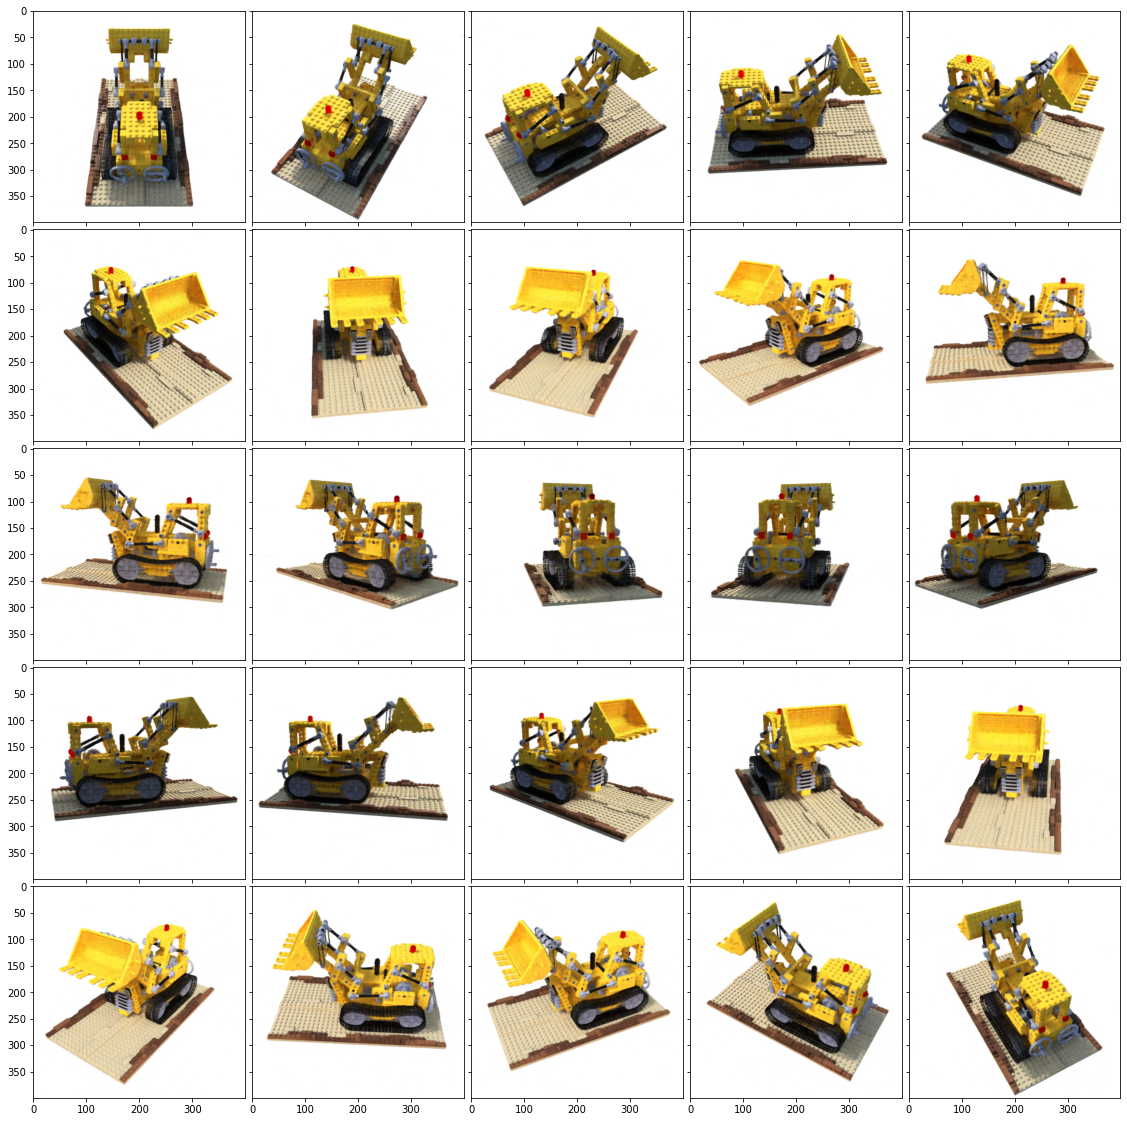

In [ ]:
import glob
from mpl_toolkits.axes_grid1 import ImageGrid

images_path = os.path.join(config.basedir, config.expname, "testset_100000/*.*")
print(images_path)
img_arr = []
for file in glob.glob(images_path):
    img = plt.imread(file)
    img_arr.append(img)

if config.dataset_type == "blender":
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111, 
                    nrows_ncols=(5, 5),  # creates 5x5 grid of axes
                    axes_pad=0.1,  # pad between axes
                    )

elif config.dataset_type == "llff":
    fig = plt.figure(figsize=(10., 5.))
    grid = ImageGrid(fig, 111, 
                    nrows_ncols=(1, 3),  # creates 1x3 grid of axes
                    axes_pad=0.1,  # pad between axes
                    )
    
for ax, im in zip(grid, img_arr):
    ax.imshow(im)

plt.show()

# Show Synthesized Video

In [ ]:
from IPython.display import HTML
from base64 import b64encode
if config.dataset_type == "blender":
    filename = "blender_paper_lego_spiral_100000_rgb.mp4"

elif config.dataset_type == "llff":
    filename = "llff_paper_fern_spiral_100000_rgb.mp4"

video_path = os.path.join(config.basedir, config.expname, filename)
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets
from load_blender import trans_t, rot_phi, rot_theta, pose_spherical
from run_nerf import create_nerf

if config.dataset_type == "blender":
    _, _, render_poses, hwf, _ = load_blender_data(args.datadir, args.half_res, args.testskip)

    near = 2.
    far = 6.  

else:
    _, _, _, render_poses, _ = load_llff_data(args.datadir, args.factor, recenter=True, bd_factor=.75, spherify=args.spherify)

    hwf = render_poses[0,:3,-1].astype(int)

    render_poses = torch.Tensor(render_poses)

    near = 0.
    far = 1.

H, W, focal = hwf

K = np.array([
    [focal, 0, 0.5*W],
    [0, focal, 0.5*H],
    [0, 0, 1]
])

_, render_kwargs_test, _, _, _ = create_nerf(args)

render_kwargs_test.update({'near' : near, 'far' : far})

def f(**kwargs):
    if config.dataset_type == "blender":
        c2w = pose_spherical(**kwargs)
    else:
        idx = int(kwargs['pose'])
        c2w = render_poses[idx]

    with torch.no_grad():
        rgb, _, _, _ = render(H, W, K, chunk=args.chunk, c2w=c2w[:3,:4], **render_kwargs_test)

    img = to8b(rgb.cpu().detach().numpy())

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    
if config.dataset_type == "blender":
    sldr = lambda v, mi, ma: widgets.FloatSlider(
        value=v,
        min=mi,
        max=ma,
        step=.01,
    )

    names = [
        ['theta', [100., 0., 360]],
        ['phi', [-30., -90, 0]],
        ['radius', [4., 3., 5.]],
    ]

else:
    sldr = lambda v, mi, ma: widgets.FloatSlider(
        value=v,
        min=mi,
        max=ma,
        step=1,
    )

    names = [['pose', [len(render_poses)//2, 0, len(render_poses)]]]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

Found ckpts ['drive/My Drive/Nerf_Colab/logs/blender_paper_lego/010000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/020000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/030000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/040000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/050000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/060000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/070000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/080000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/090000.tar', 'drive/My Drive/Nerf_Colab/logs/blender_paper_lego/100000.tar']
Reloading from drive/My Drive/Nerf_Colab/logs/blender_paper_lego/100000.tar
Not ndc!


interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…